# Protein Preparation Tutorial

This notebook demonstrates how to prepare protein structures for molecular docking using the drugforge toolkit.

## Setup

First, let's import the necessary modules

In [1]:
from drugforge.data.testing.test_resources import fetch_test_file
from drugforge.data.schema.complex import Complex
from drugforge.modeling.schema import PreppedComplex
from drugforge.modeling.protein_prep import ProteinPrepper

Next we setup the example data

In [2]:
complex_pdb = Complex.from_pdb(
        fetch_test_file("structure_dir/Mpro-x0354_0A_bound.pdb"),
        target_kwargs={"target_name": "test"},
        ligand_kwargs={"compound_name": "test2"},
    )

Let's examine it

In [3]:
complex_pdb.target

Target(target_name='test', ids=None, data_format=<DataStorageType.pdb: 'pdb'>)

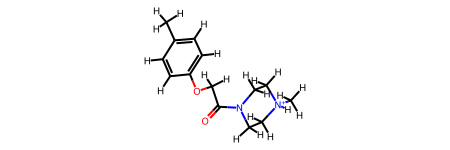

In [4]:
complex_pdb.ligand.to_rdkit()

# Now we prep the protein using OpenEye

In [5]:
# this is used by OpenEye to fill in any missing loops
loop_db = fetch_test_file("fragalysis-mpro_spruce.loop_db")
target = "SARS-CoV-2"

In [6]:
# this will take ~30 seconds
prepper = ProteinPrepper(loop_db=loop_db)
pcs = prepper.prep([complex_pdb], use_dask=False)

Adding loop db


No BioAssembly transforms found, using input molecule as biounit: _chainA._chainB_LIG
Processing BU # 1 with title: _chainA._chainB_LIG, chains AB


In [7]:
prepped_complex = pcs[0]

In [8]:
prepped_complex

PreppedComplex(target=PreppedTarget(target_name='test', ids=None, data_format=<DataStorageType.b64oedu: 'b64oedu'>, target_hash='9e2ea19d1a175314647dacb9d878138a80b8443cff5faf56031bf4af61179a0a', crystal_symmetry=None), ligand=Ligand(compound_name='test2', ids=None, provenance=LigandProvenance(isomeric_smiles='Cc1ccc(cc1)OCC(=O)N2CC[NH+](CC2)C', inchi='InChI=1S/C14H20N2O2/c1-12-3-5-13(6-4-12)18-11-14(17)16-9-7-15(2)8-10-16/h3-6H,7-11H2,1-2H3/p+1', inchi_key='GIIIJZOPGUFGBF-UHFFFAOYSA-O', fixed_inchi='InChI=1/C14H20N2O2/c1-12-3-5-13(6-4-12)18-11-14(17)16-9-7-15(2)8-10-16/h3-6H,7-11H2,1-2H3/p+1/fC14H21N2O2/h15H/q+1', fixed_inchikey='GIIIJZOPGUFGBF-QXYFZJGFNA-O'), experimental_data=None, expansion_tag=None, charge_provenance=None, bespoke_parameters=None, tags={}, conf_tags={}, data_format=<DataStorageType.sdf: 'sdf'>))

Since we used the OpenEye prepper, we'll get a result that is basically a wrapper around the OpenEye design unit object. We can get the DesignUnit directly with:

In [9]:
du = prepped_complex.target.to_oedu()
print(du.HasReceptor())
print(du.HasLigand())

True
True


We can save the pdb, design unit, and ligand sdfs.

In [10]:
prepped_complex.target.to_oedu_file("test_prepped_complex.oedu")

In [11]:
prepped_complex.target.to_pdb_file("test_prepped_complex.pdb")

In [12]:
prepped_complex.ligand.to_sdf("test_prepped_complex.sdf")

We can serialize this whole object as a json as well! 

In [13]:
prepped_complex.to_json_file("test_prepped_complex.json")

In [14]:
loaded = PreppedComplex.from_json_file("test_prepped_complex.json")

In [15]:
loaded == prepped_complex

True

# Other Utilities

While the whole protein prep workflow is in `drugforge.workflows.prep_workflows`, the majority of the functionality is in `drugforge.modeling`. 

Currently we've just implemented the default OpenEye protein prepper (used above), and the LigandTransferProteinPrepper, which creates a new prepped complex by transfering the ligand from an existing complex to an apo structure. This was useful for us in particular for generating complexes with, i.e. MERS bound to Ligand A, when we only had SARS-CoV-2 bound to ligand A. 